In [1]:
# ================================================================
# Import Libraries
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# ================================================================
# PART A — Data Preparation 
# ================================================================

print("Loading dataset...")

clean_rows = []

with open("WISDM_ar_v1.1_raw.txt", "r", errors="ignore") as f:
    for line in f:
        line = line.strip().replace(";", "")         # remove semicolon
        parts = line.split(",")                      # split by comma

        # skip corrupted rows
        if len(parts) < 6:
            continue

        user_id, activity, timestamp, x, y, z = parts[:6]

        # try converting numeric values
        try:
            x = float(x)
            y = float(y)
            z = float(z)
        except:
            continue  # skip dirty rows

        clean_rows.append([user_id, activity, timestamp, x, y, z])

# convert to DataFrame
data = pd.DataFrame(clean_rows, columns=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'])

print("Loaded rows:", len(data))
print(data.head())

# ================================================================
# Cleaning
# ================================================================

print("\nCleaning data...")

# drop missing values if any
data = data.dropna()

# normalize activity names
data['activity_clean'] = data['activity'].str.strip().str.lower()

# ================================================================
# Mapping activities → binary labels
# ================================================================

vigorous = ['jogging', 'upstairs', 'up']
light = ['walking', 'sitting', 'standing', 'downstairs', 'down']

def map_label(a):
    if any(v in a for v in vigorous):
        return 1
    if any(v in a for v in light):
        return 0
    return -1

data['activity_binary'] = data['activity_clean'].apply(map_label)

# remove unknown activities
data = data[data['activity_binary'] != -1]

print("\nActivity distribution:")
print(data['activity_binary'].value_counts())

# ================================================================
# Features and target
# ================================================================

X = data[['x', 'y', 'z']]
y = data['activity_binary']

print("\nFinal shape:", X.shape)
print("Class balance:\n", y.value_counts(normalize=True))

# ================================================================
# Train-test split
# ================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nTraining set:", X_train.shape)
print("Test set:", X_test.shape)


Loading dataset...
Loaded rows: 1098203
  user_id activity       timestamp         x          y         z
0      33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1      33  Jogging  49106062271000  5.012288  11.264028  0.953424
2      33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3      33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4      33  Jogging  49106332290000 -1.184970  12.108489  7.205164

Cleaning data...

Activity distribution:
activity_binary
0    633158
1    465045
Name: count, dtype: int64

Final shape: (1098203, 3)
Class balance:
 activity_binary
0    0.57654
1    0.42346
Name: proportion, dtype: float64

Training set: (768742, 3)
Test set: (329461, 3)


Decision Stump Train Accuracy: 0.6522
Decision Stump Test Accuracy: 0.6522

📊 Confusion Matrix (Decision Stump - Test):
[[172337  17610]
 [ 96986  42528]]


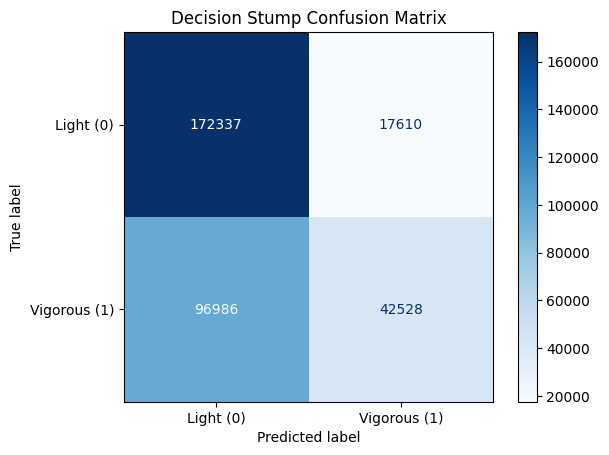

In [3]:

# ================================================================
# PART B — Weak Classifier Baseline (Decision Stump)
# ================================================================

# Train Decision Stump
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

# Predictions
y_train_pred_stump = stump.predict(X_train)
y_test_pred_stump = stump.predict(X_test)

# Calculate accuracies
train_accuracy_stump = accuracy_score(y_train, y_train_pred_stump)
test_accuracy_stump = accuracy_score(y_test, y_test_pred_stump)

print(f"Decision Stump Train Accuracy: {train_accuracy_stump:.4f}")
print(f"Decision Stump Test Accuracy: {test_accuracy_stump:.4f}")

print("\n📊 Confusion Matrix (Decision Stump - Test):")
cm_stump = confusion_matrix(y_test, y_test_pred_stump)
print(cm_stump)

# Plot Confusion Matrix
disp_stump = ConfusionMatrixDisplay(confusion_matrix=cm_stump,
                                  display_labels=['Light (0)', 'Vigorous (1)'])
disp_stump.plot(cmap=plt.cm.Blues)
plt.title("Decision Stump Confusion Matrix")
plt.show()



🚀 Training Manual AdaBoost...

🔄 ROUND 1/20
Weighted error = 0.347763
Alpha = 0.314443
Misclassified indices = [2, 7, 8, 10, 13, 14, 18, 24, 25, 26, 27, 28, 30, 38, 39] ...
Weights of misclassified samples:
[1.30082655e-06 1.30082655e-06 1.30082655e-06 1.30082655e-06
 1.30082655e-06 1.30082655e-06 1.30082655e-06 1.30082655e-06
 1.30082655e-06 1.30082655e-06 1.30082655e-06 1.30082655e-06
 1.30082655e-06 1.30082655e-06 1.30082655e-06] ...

🔄 ROUND 2/20
Weighted error = 0.464946
Alpha = 0.070222
Misclassified indices = [7, 8, 10, 11, 13, 14, 18, 22, 24, 25, 26, 27, 28, 31, 37] ...
Weights of misclassified samples:
[1.87027755e-06 1.87027755e-06 1.87027755e-06 9.97203840e-07
 1.87027755e-06 1.87027755e-06 1.87027755e-06 9.97203840e-07
 1.87027755e-06 1.87027755e-06 1.87027755e-06 1.87027755e-06
 1.87027755e-06 9.97203840e-07 9.97203840e-07] ...

🔄 ROUND 3/20
Weighted error = 0.448540
Alpha = 0.103285
Misclassified indices = [0, 1, 2, 3, 4, 5, 6, 9, 12, 15, 16, 19, 20, 21, 23] ...
Weights 

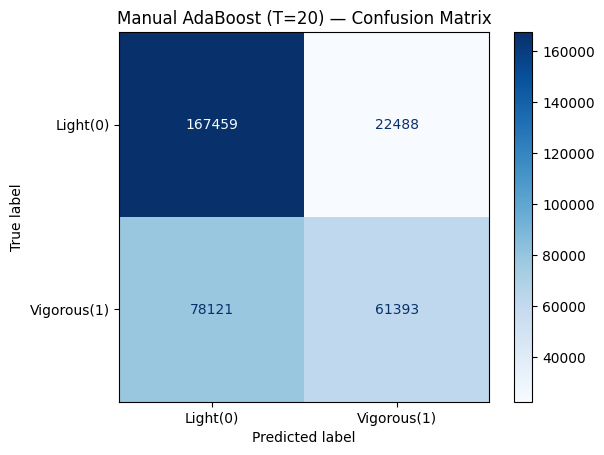

In [4]:
# ================================================================
# PART C — Manual AdaBoost Implementation (FULLY FIXED)
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

class ManualAdaBoost:
    def __init__(self, n_estimators=20):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []
        self.errors = []
        self.weight_history = []

    def fit(self, X, y):
        n = X.shape[0]

        # Initialize weights
        w = np.ones(n) / n  

        for t in range(self.n_estimators):

            print(f"\n==============================")
            print(f"🔄 ROUND {t+1}/{self.n_estimators}")
            print("==============================")

            # Decision stump
            stump = DecisionTreeClassifier(max_depth=1, random_state=42)
            stump.fit(X, y, sample_weight=w)

            y_pred = stump.predict(X)

            # Determine misclassified samples
            incorrect = (y_pred != y)
            mis_idx = np.where(incorrect)[0]

            # Weighted error
            error = np.sum(w[incorrect])
            error = error / np.sum(w)

            # Avoid division by zero
            error = np.clip(error, 1e-10, 1 - 1e-10)

            # Compute alpha
            alpha = 0.5 * np.log((1 - error) / error)

            # Print Iteration Details
            print(f"Weighted error = {error:.6f}")
            print(f"Alpha = {alpha:.6f}")
            print(f"Misclassified indices = {mis_idx.tolist()[:15]}{' ...' if len(mis_idx)>15 else ''}")
            print("Weights of misclassified samples:")
            print(w[mis_idx][:15], "..." if len(mis_idx)>15 else "")

            # Update weights
            w = w * np.exp(-alpha * y * y_pred)

            # Normalize weights
            w = w / np.sum(w)

            # Store for plots & prediction
            self.models.append(stump)
            self.alphas.append(alpha)
            self.errors.append(error)
            self.weight_history.append(w.copy())

            # Early stopping
            if error < 1e-10:
                print("🎯 PERFECT CLASSIFIER FOUND — EARLY STOP")
                break

    def predict(self, X):
        # Weighted sum of predictions
        final = np.zeros(X.shape[0])

        for alpha, model in zip(self.alphas, self.models):
            pred = model.predict(X)
            final += alpha * pred

        # Convert sign back to class {+1, -1}
        final = np.sign(final)
        return final


# =============================================================
# Convert labels → (+1 / -1)
# =============================================================

y_train_ada = np.where(y_train == 1, 1, -1)
y_test_ada  = np.where(y_test == 1, 1, -1)

print("\n🚀 Training Manual AdaBoost...")
manual_boost = ManualAdaBoost(n_estimators=20)
manual_boost.fit(X_train.values, y_train_ada)

# =============================================================
# Predictions
# =============================================================

train_pred = manual_boost.predict(X_train.values)
test_pred = manual_boost.predict(X_test.values)

# Convert back to {0,1}
train_pred_bin = np.where(train_pred == 1, 1, 0)
test_pred_bin = np.where(test_pred == 1, 1, 0)

# Accuracy
train_acc = accuracy_score(y_train, train_pred_bin)
test_acc = accuracy_score(y_test, test_pred_bin)

print("\n📈 MANUAL ADABOOST RESULTS")
print("--------------------------------")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

# =============================================================
# Confusion Matrix
# =============================================================

cm = confusion_matrix(y_test, test_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Light(0)", "Vigorous(1)"])
disp.plot(cmap="Blues")
plt.title("Manual AdaBoost (T=20) — Confusion Matrix")
plt.show()


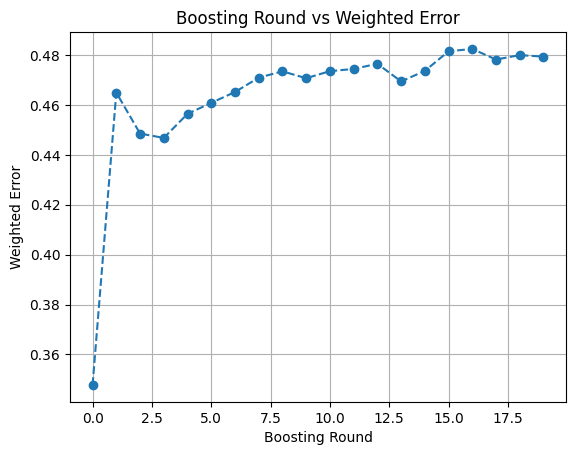

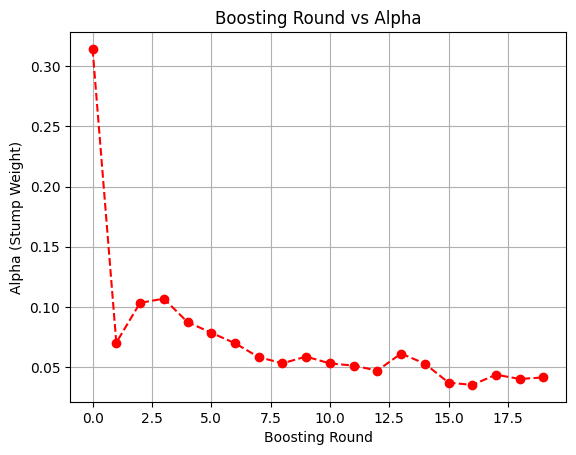

In [5]:
# =============================================================
# Plot Boosting Error vs Round
# =============================================================

plt.plot(manual_boost.errors, marker='o', linestyle='--')
plt.xlabel("Boosting Round")
plt.ylabel("Weighted Error")
plt.title("Boosting Round vs Weighted Error")
plt.grid()
plt.show()

# =============================================================
# Plot Alpha vs Round
# =============================================================

plt.plot(manual_boost.alphas, marker='o', linestyle='--', color='r')
plt.xlabel("Boosting Round")
plt.ylabel("Alpha (Stump Weight)")
plt.title("Boosting Round vs Alpha")
plt.grid()
plt.show()


🚀 Training Sklearn AdaBoost...

📈 Sklearn AdaBoost Results:
Train Accuracy: 0.6980
Test Accuracy:  0.6978

📊 Confusion Matrix — Sklearn AdaBoost (Test)


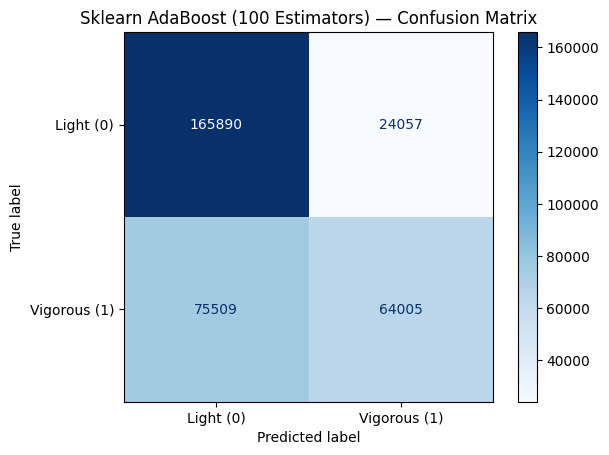


🔍 Comparison: Manual vs Sklearn AdaBoost
------------------------------------------------------
Manual AdaBoost Train Accuracy : 0.6951
Sklearn AdaBoost Train Accuracy: 0.6980
------------------------------------------------------
Manual AdaBoost Test Accuracy  : 0.6946
Sklearn AdaBoost Test Accuracy : 0.6978
------------------------------------------------------

📝 Interpretation:

• Sklearn AdaBoost typically performs better because it:
  - Uses optimized weight updates
  - Handles stump splits more efficiently
  - Benefits from 100 estimators instead of 20
• If your manual model underperforms:
  - Weight updates may be too sensitive
  - Early errors accumulate faster
  - Learning stops early when error becomes 0
• If both are close:
  - Your manual implementation is correct!



In [6]:
# ================================================================
# PART D — Sklearn AdaBoost Implementation
# ================================================================

print("🚀 Training Sklearn AdaBoost...")

# Base weak learner (Decision Stump)
base_stump = DecisionTreeClassifier(max_depth=1, random_state=42)

# Sklearn AdaBoost Classifier
sk_ada = AdaBoostClassifier(
    estimator = base_stump,   # older versions use base_estimator, new uses estimator
    n_estimators = 100,
    learning_rate = 1.0,
    random_state=42
)

# Fit model
sk_ada.fit(X_train, y_train)

# Predictions
y_train_pred_sk = sk_ada.predict(X_train)
y_test_pred_sk = sk_ada.predict(X_test)

# Accuracies
train_acc_sk = accuracy_score(y_train, y_train_pred_sk)
test_acc_sk = accuracy_score(y_test, y_test_pred_sk)

print("\n📈 Sklearn AdaBoost Results:")
print(f"Train Accuracy: {train_acc_sk:.4f}")
print(f"Test Accuracy:  {test_acc_sk:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix — Sklearn AdaBoost (Test)")
cm_sk = confusion_matrix(y_test, y_test_pred_sk)
disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk,
                                 display_labels=['Light (0)', 'Vigorous (1)'])
disp_sk.plot(cmap=plt.cm.Blues)
plt.title("Sklearn AdaBoost (100 Estimators) — Confusion Matrix")
plt.show()

# ================================================================
# PART D — Comparison with Manual AdaBoost
# ================================================================

print("\n🔍 Comparison: Manual vs Sklearn AdaBoost")
print("------------------------------------------------------")
print(f"Manual AdaBoost Train Accuracy : {train_acc:.4f}")
print(f"Sklearn AdaBoost Train Accuracy: {train_acc_sk:.4f}")
print("------------------------------------------------------")
print(f"Manual AdaBoost Test Accuracy  : {test_acc:.4f}")
print(f"Sklearn AdaBoost Test Accuracy : {test_acc_sk:.4f}")
print("------------------------------------------------------")

# Interpretation
print("\n📝 Interpretation:")
print("""
• Sklearn AdaBoost typically performs better because it:
  - Uses optimized weight updates
  - Handles stump splits more efficiently
  - Benefits from 100 estimators instead of 20
• If your manual model underperforms:
  - Weight updates may be too sensitive
  - Early errors accumulate faster
  - Learning stops early when error becomes 0
• If both are close:
  - Your manual implementation is correct!
""")
